# HAVOK method with optimally thresholded SVD

In [1]:
import numpy as np
from numpy import random
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.SVD_thresholding import *
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
import cvxpy as cp
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

## Data for training

(<matplotlib.legend.Legend at 0x2bd37f57eb0>,
 <matplotlib.legend.Legend at 0x2bd37f70a60>)

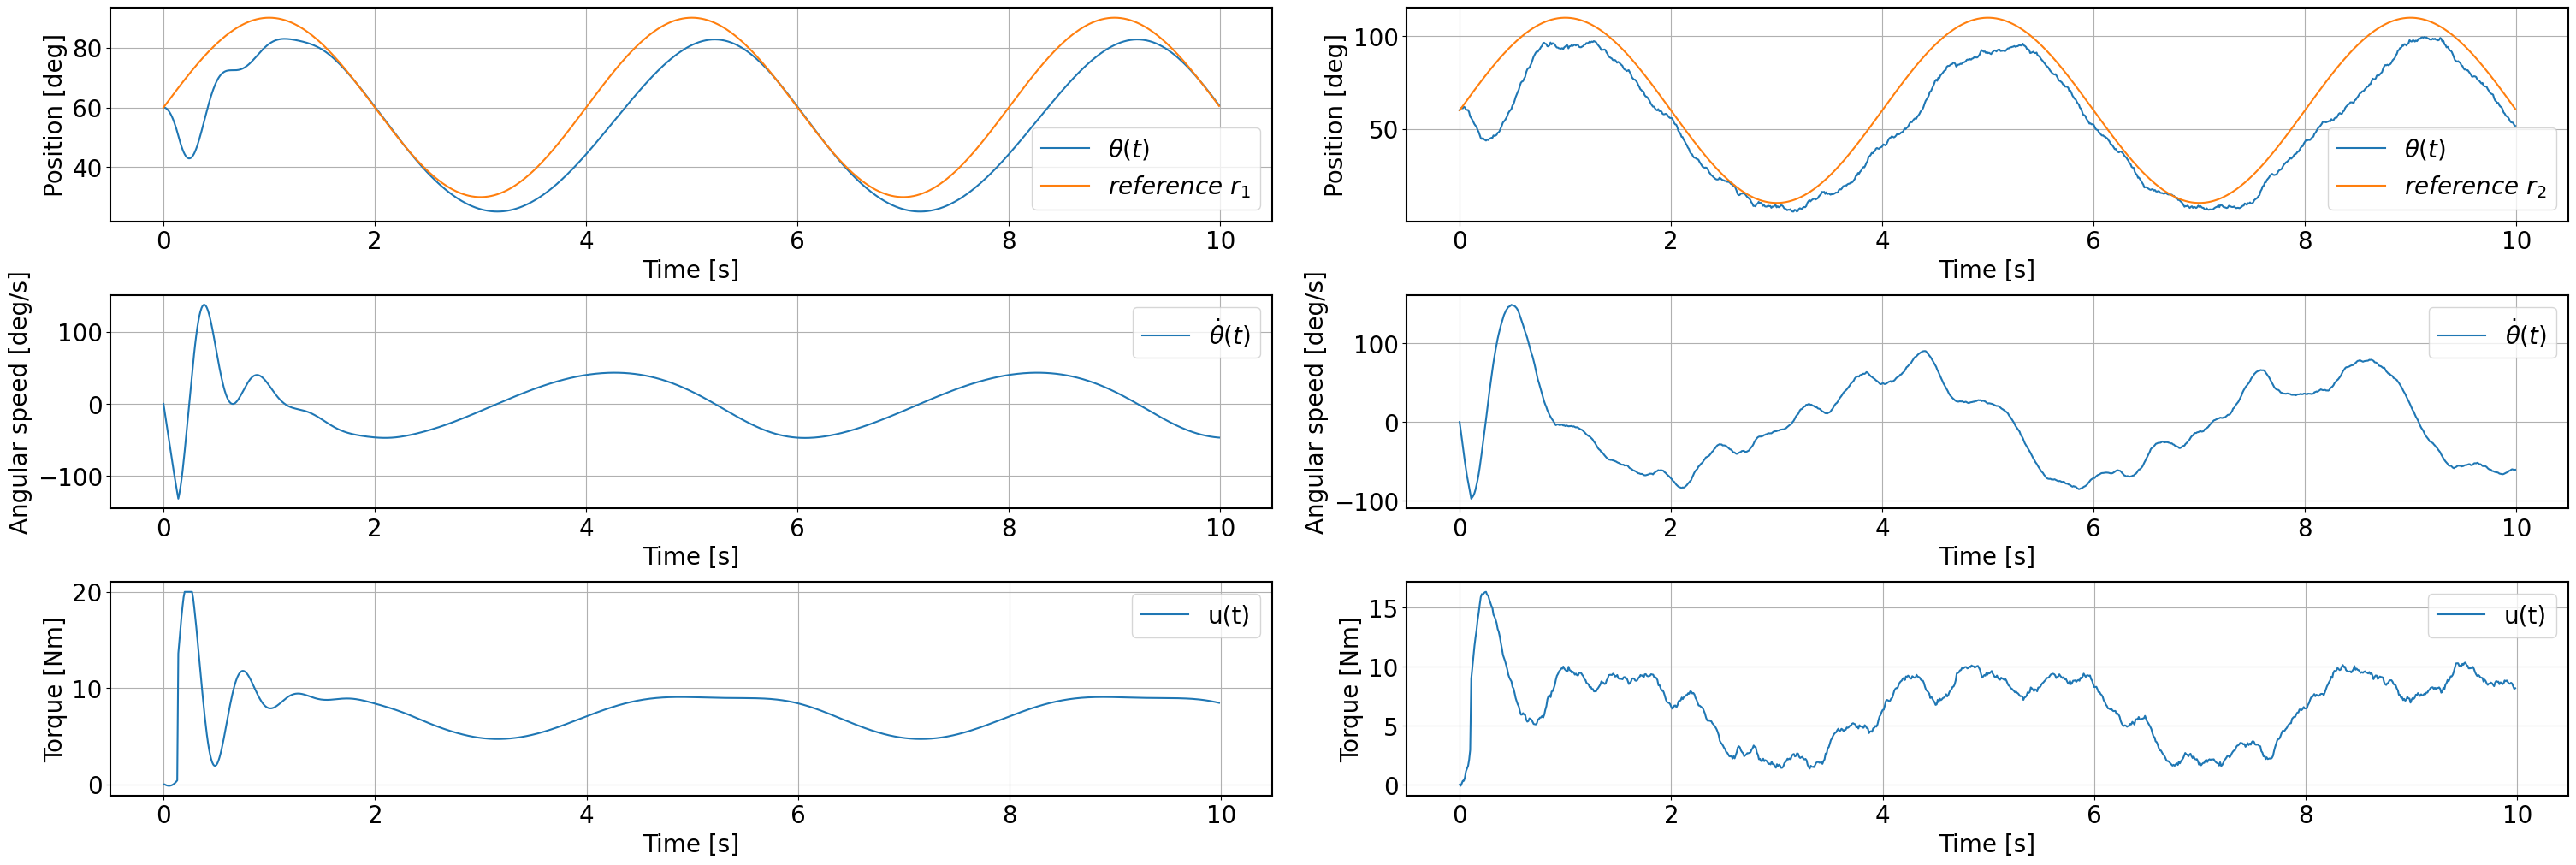

In [42]:
# Pendulum instance
dt = 1e-2
pend1 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(60),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(60),0]), dt=dt)

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Reference design
freq = .25
pend1.T_ref, pend2.T_ref = 1/freq/pend1.dt, 1/freq/pend2.dt
amplitude1, amplitude2 = 30, 50 # deg
pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 60)
# pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
# pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(70),deg2rad(30)], np.int(pend1.T_ref/10), 0)
pend2.ref = sineReference(pend1.N, pend1.dt, pend2.T_ref, amplitude2, 60)

# Simulation

for i in range(pend1.N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], 10, 1, 40, pend1.dt, 13, limit=20)[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 15, 0, 25, pend2.dt, 10, limit=20)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step') + np.random.normal(0,.01,2)
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend1.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]'), ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend1.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Angular speed [deg/s]'), ax[1,1].set_xlabel('Time [s]'), ax[1,1].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend1.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]'), ax[2,1].set_ylabel('Torque [Nm]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

## Hankel matrix optimal thresholding according to *Gavish et Al.*

93


([<matplotlib.lines.Line2D at 0x2bd43899640>],
 Text(0.5, 0, 'i'),
 Text(0, 0.5, '$log(\\sigma_i)$'),
 Text(0.5, 1.0, 'Hankel matrix log-singular values'))

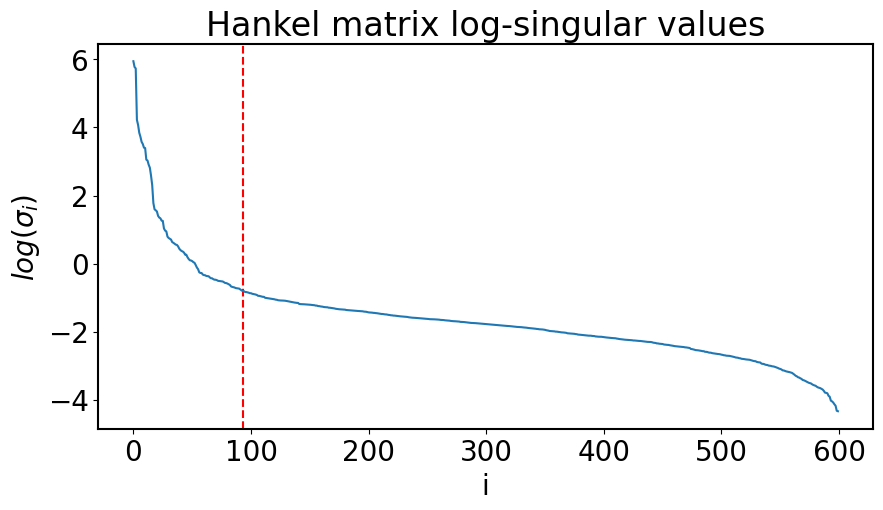

In [54]:
pend = pend2
horizon = 300
model1 = HAVOK(pend.X, pend.U)
X0 = [deg2rad(60),0]

nb_delay = [1,2,3,4,5,7,10,15]
# nb_delay = [5]
nb_plots = len(nb_delay)

# Optimal threshold stuff ########################################
model1.HANKEL(horizon)
U, S, Vh = svd(model1.H)
k = optht(model1.H, S, sigma=None)

print(k)
plt.figure(figsize=[10,5])
plt.axvline(k, color='r', linestyle='dashed')
plt.plot(np.log(S)), plt.xlabel('i'), plt.ylabel(r'$log(\sigma_i)$'), plt.title('Hankel matrix log-singular values')

### Low rank model and simulation

Text(947.4582557475677, 0.5, 'Embedded state number')

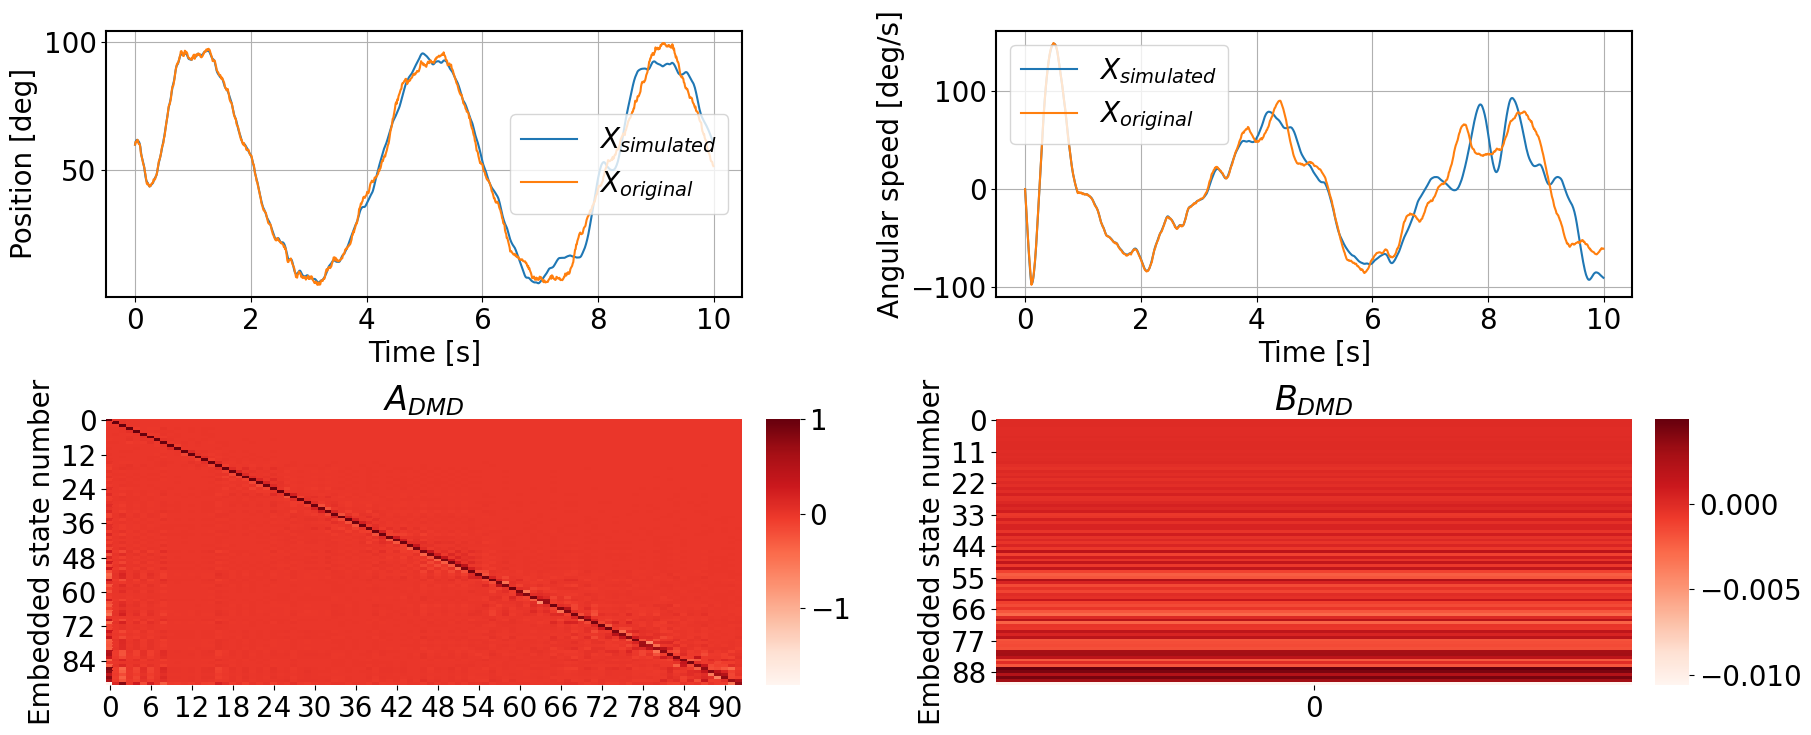

In [58]:
pend = pend2
horizon = 300
model1 = HAVOK(model1.X, pend.U)
model1.HANKEL(horizon)
model1.SVD(tau=k) # Perfect reconstruction from tau=11 and on
model1.LS()
X0 = [deg2rad(60),0]
model1.Simulate(X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(model1.X_traj[0,:]), label=r"$X_{simulated}$")
ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$X_{original}$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.X_traj[1,:]), label=r"$X_{simulated}$")
ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$X_{original}$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].set_title(r'$A_{DMD}$')
snb.heatmap(model1.A, ax=ax[1,0], cmap='Reds')
ax[1,0].set_ylabel('Embedded state number')

ax[1,1].set_title(r'$B_{DMD}$')
snb.heatmap(model1.B, cmap='Reds')
ax[1,1].set_ylabel('Embedded state number')

In [ ]:
# Simulate the closed-loop system
N = np.eye(model1.tau) - pinv(model1.C)@model1.C # Nullspace projection operator
Y0 = np.zeros((1,model1.tau))
Y0[0,:] = pinv(model1.C)@pend.X0 + N@(model1.Y[:,0] - pinv(model1.C)@pend.X0)
ys, us = lqr_tracking.make_rollout(Y0)
ys_mean = np.mean(ys, axis=0)
xs = model1.C@ys_mean.T # Map back to original space
xs = xs.T

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(xs[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(xs[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], us[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(lqr_tracking._K)[:,0,:].T)
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Delay $\tau$')

Text(948.4775126984122, 0.5, 'Embedded state number')

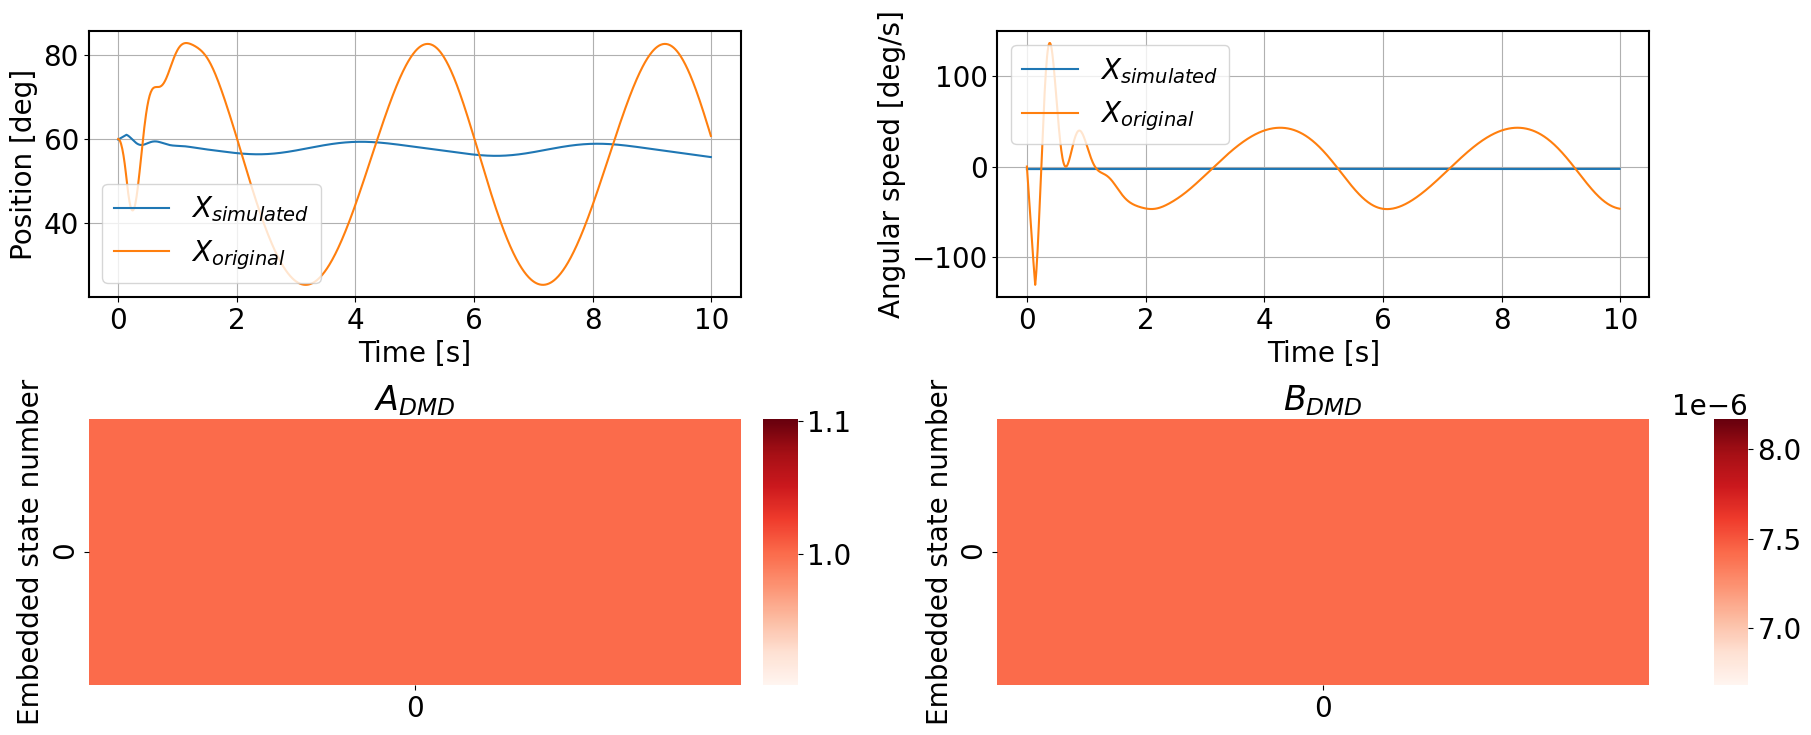

In [63]:
pend = pend1
horizon = 300
model1 = HAVOK(pend.X, pend.U)
model1.HANKEL(horizon)
model1.SVD(tau=1) # Perfect reconstruction from tau=11 and on
model1.LS()
X0 = [deg2rad(60),0]
model1.Simulate(X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(model1.X_traj[0,:]), label=r"$X_{simulated}$")
ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$X_{original}$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.X_traj[1,:]), label=r"$X_{simulated}$")
ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$X_{original}$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].set_title(r'$A_{DMD}$')
snb.heatmap(model1.A, ax=ax[1,0], cmap='Reds')
ax[1,0].set_ylabel('Embedded state number')

ax[1,1].set_title(r'$B_{DMD}$')
snb.heatmap(model1.B, cmap='Reds')
ax[1,1].set_ylabel('Embedded state number')

## Low-rank approximation using mixed-integer convex optimisation framework

In [62]:
U, S, Vt = svd(model1.H, full_matrices=False)
m, n = model1.H.shape[0], model1.H.shape[1]
M = min(m,n)
nu = 100

mu = cp.Variable((M,1),integer=True) # Sparsity promoting variable
# Sk = cp.diag(S)@cp.diag(mu)
# H = U@np.diag(S)@Vt # Original matrix (reduced)
# Hk = U@Sk@Vt # Low rank approximation
print(S.shape, mu.shape, M)

# objective = cp.Minimize(cp.square(cp.norm(H - Hk,'fro')) + alpha*cp.trace(Sk))
# frobenius_norm = cp.vec(H-Hk)
print('Objective')
ones = np.ones((M,1))
S2 = np.square(S)
# objective = cp.Minimize(ones.T@np.diag(S2)@ones - 2*ones.T@np.diag(S2)@mu + cp.sum_squares(cp.multiply(S2[:,np.newaxis],cp.square(mu))) + nu*cp.sum_squares(mu))
# objective = cp.Minimize(ones.T@np.diag(S2)@ones - 2*ones.T@np.diag(S2)@mu + cp.sum_squares(cp.multiply(S2[:,np.newaxis],cp.square(mu))))
objective = cp.Minimize(cp.sum_squares(np.diag(S)@(np.ones((M,1)) - mu)) + nu*cp.sum_squares(mu))
# obj1 = cp.Minimize(cp.norm(U@S@(np.eye(M) - cp.diag(mu))@Vt,"fro"))
# obj1 = cp.Minimize(cp.sum_squares(np.diag(S)@np.ones((M,1)) - mu))
print(obj1.is_dcp())

# Must only keep SV in increasing importance order
print('Constraints')
constraints = []
# for i in range(M-1):
#       constraints.append(mu[i]*S[i] >= mu[i+1]*S[i+1])
        
# Binary variable mu must be 0 or 1
for i in range(M):
    constraints.extend([mu[i] <= 1 , mu[i] >= 0])
constraints.extend([mu <= np.ones((M,1)) , mu >= np.zeros((M,1))])

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True)
print('Number of embedded space dimension : ',np.sum(mu.value))

(600,) (600, 1) 600
Objective
True
Constraints
                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Oct 28 03:52:03 PM: Your problem has 600 variables, 1202 constraints, and 0 parameters.
(CVXPY) Oct 28 03:52:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 28 03:52:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 28 03:52:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 28 03:52:03 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 28 03:52:03 PM: Reduction chain: